 The challenge is to predict Workers Compensation claims using highly realistic synthetic data.

 The evaluation method is Root Mean Squared Error (RMSE)

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_tree
from sklearn.metrics import mean_squared_error

In [107]:
df = pd.read_csv("train.csv", parse_dates=["DateReported", "DateTimeOfAccident"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   ClaimNumber                54000 non-null  object             
 1   DateTimeOfAccident         54000 non-null  datetime64[ns, UTC]
 2   DateReported               54000 non-null  datetime64[ns, UTC]
 3   Age                        54000 non-null  int64              
 4   Gender                     54000 non-null  object             
 5   MaritalStatus              53971 non-null  object             
 6   DependentChildren          54000 non-null  int64              
 7   DependentsOther            54000 non-null  int64              
 8   WeeklyWages                54000 non-null  float64            
 9   PartTimeFullTime           54000 non-null  object             
 10  HoursWorkedPerWeek         54000 non-null  float64            
 11  Da

### Preprocessing

In [108]:
# replace nan values with unknown 
df["MaritalStatus"] = df["MaritalStatus"].fillna('Unknown')
df["MaritalStatus"].unique()

array(['M', 'U', 'S', 'Unknown'], dtype=object)

In [109]:
df[["Gender", "MaritalStatus", "PartTimeFullTime"]] = df[
    ["Gender", "MaritalStatus", "PartTimeFullTime"]
].astype("category")

### Feature Engineering

In [110]:
def index_place(df: pd.DataFrame, column_name) -> None:
    col_index = df.columns.get_loc("DateTimeOfAccident")

    # make sure it's int to suppress error
    if not isinstance(col_index, int):
        raise ValueError("`datetime_col_index` must be an integer.")

    df.insert(col_index + 1, "DateOfAccident", df.pop("DateOfAccident"))
    df.insert(col_index + 2, "TimeOfAccident", df.pop("TimeOfAccident"))


In [111]:
df["DateOfAccident"] = df["DateTimeOfAccident"].dt.date
df["TimeOfAccident"] = df["DateTimeOfAccident"].dt.time

col_index = df.columns.get_loc("DateTimeOfAccident")

# make sure it's int to suppress error
if not isinstance(col_index, int):
    raise ValueError("`datetime_col_index` must be an integer.")

df.insert(col_index + 1, "DateOfAccident", df.pop("DateOfAccident"))
df.insert(col_index + 2, "TimeOfAccident", df.pop("TimeOfAccident"))

df["DateOfAccident"] = pd.to_datetime(df["DateOfAccident"], format="ISO8601", utc=True)
# df["TimeOfAccident"] = pd.to_datetime(df["TimeOfAccident"], format="%H:%M:%S", utc=True)

In [112]:
# Convert dates to format a model can understand
df['AccidentDay'] = df['DateTimeOfAccident'].dt.day
df['AccidentMonth'] = df['DateTimeOfAccident'].dt.month
df['AccidentYear'] = df['DateTimeOfAccident'].dt.year
df['AccidentWeekday'] = df['DateTimeOfAccident'].dt.weekday
df['ReportedDay'] = df['DateReported'].dt.day
df['ReportedMonth'] = df['DateReported'].dt.month
df['ReportedYear'] = df['DateReported'].dt.year
df['ReportedWeekday'] = df['DateReported'].dt.weekday

In [113]:
df_encoded = pd.get_dummies(
    df[
        [
            # "ClaimNumber",
            # "DateTimeOfAccident",
            # "DateOfAccident",
            # "TimeOfAccident",
            # "DateReported",
            "Age",
            "Gender",
            "MaritalStatus",
            "DependentChildren",
            "DependentsOther",
            "WeeklyWages",
            "PartTimeFullTime",
            "HoursWorkedPerWeek",
            "DaysWorkedPerWeek",
            # "ClaimDescription",
            "InitialIncurredCalimsCost",
            "UltimateIncurredClaimCost",
            "AccidentDay",
            "AccidentMonth",
            "AccidentYear",
            "AccidentWeekday",
            "ReportedDay",
            "ReportedMonth",
            "ReportedYear",
            "ReportedWeekday",
        ]
    ],
)
df_encoded.shape

(54000, 25)

In [114]:
df_encoded.columns

Index(['Age', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'HoursWorkedPerWeek', 'DaysWorkedPerWeek', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost', 'AccidentDay', 'AccidentMonth',
       'AccidentYear', 'AccidentWeekday', 'ReportedDay', 'ReportedMonth',
       'ReportedYear', 'ReportedWeekday', 'Gender_F', 'Gender_M', 'Gender_U',
       'MaritalStatus_M', 'MaritalStatus_S', 'MaritalStatus_U',
       'MaritalStatus_Unknown', 'PartTimeFullTime_F', 'PartTimeFullTime_P'],
      dtype='object')

### Train model

In [115]:
X = df_encoded.drop(columns=['UltimateIncurredClaimCost'])
y = df_encoded.UltimateIncurredClaimCost

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [125]:
params = {
    "objective": "reg:squarederror",  # Regression objective
    "n_estimators": 100,  # Number of trees (boosting rounds)
    "learning_rate": 0.01,  # Learning rate
    "max_depth": 3,  # Maximum depth of each tree
    "min_child_weight": 3,  # Minimum sum of instance weight (hessian) in a child
    "subsample": 0.8,  # Proportion of training data used for each tree
    "colsample_bytree": 0.8,  # Fraction of features used for each tree
    "gamma": 0.1,  # Minimum loss reduction to make a further partition on a leaf node
    "reg_alpha": 0,  # L1 regularization term
    "reg_lambda": 0,  # L2 regularization term
    "seed": 42,  # Random seed for reproducibility
}


In [126]:
model = XGBRegressor(**params)
model.fit(X_train, y_train);

### Evaluate model

In [127]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 26416.249366011707


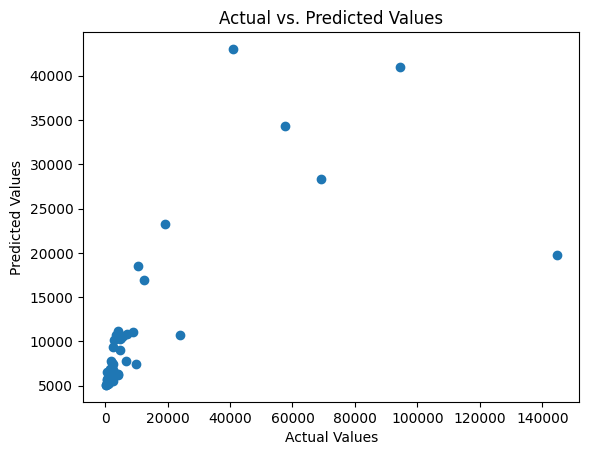

In [129]:
plt.scatter(y_test[:50], y_pred[:50])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.ticklabel_format(style='plain')
plt.title("Actual vs. Predicted Values")
plt.show()

In [120]:
# Create a DataFrame with y_pred and y_test as columns
df_pred = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})

# Print the DataFrame
df_pred["diff"] = df_pred["y_test"] - df_pred["y_pred"]
df_pred.head(20).apply(lambda x: x.apply('{0:.5f}'.format))

,y_pred,y_test,diff
30246,5781.68750,4186.83823,-1594.84927
34164,4056.08032,1805.47570,-2250.60462
40692,9201.83789,2679.33946,-6522.49844
28724,278.47910,525.62733,247.14823
28097,93.50453,3859.03818,3765.53365
31492,41295.83984,144567.47040,103271.63056
7950,9035.00195,4633.23118,-4401.77077
40973,124786.66406,94457.47335,-30329.19071
4448,9886.67285,19168.43094,9281.75809
26354,2131.66992,2133.62325,1.95333


In [121]:
df_pred.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,y_pred,y_test,diff
count,10800.00000,10800.00000,10800.00000
mean,11606.57715,10990.98864,-615.58842
std,25260.19141,30132.06620,30479.78298
min,-357499.78125,123.16488,-905571.72187
25%,1463.18744,910.73964,-5184.45507
50%,5376.97510,3409.28618,-1457.37815
75%,12554.83594,8172.21420,1171.48480
max,950984.00000,865770.64860,859732.28630


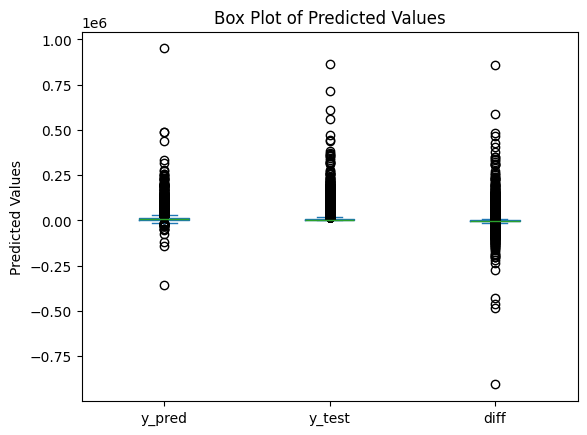

In [124]:
df_pred.plot(kind='box')
plt.title('Box Plot of Predicted Values')
plt.ylabel('Predicted Values')
plt.show()